## Задание

ДЗ - оценить возраст человека по изображению. В качестве датасета возьмите датасет только лиц. 
Предположим что сами лица вы находить и извлекать уже умеете. Можете сделать это как продолжение решения по поиску лиц из предыдущих работ.
https://www.google.com/amp/s/www.geeksforgeeks.org/age-detection-using-deep-learning-in-opencv/amp/ пример того как это может работать.  
В качестве фьючеэкстрактора берите любую современную нейронную сеть. Задачу можно решать как задачу регрессии или классификации.  14 14-18 
Если есть время можете попробовать 2 способа.  Попробуйте разблокировать часть слоев после обучения и дообучить модель.

## Решение

In [1]:
import os
import cv2 
import mediapipe as mp

import re
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [11]:
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection()

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

main_folder = 'wiki_crop' 
output_folder = 'final_folder'

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

for root, dirs, files in os.walk(main_folder):
    for filename in files:
        if filename.endswith((".jpg", ".jpeg", ".png")):
            try:
                image_file = os.path.join(root, filename)

                image = cv2.imread(image_file)
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Получение размеров изображения
                height, width, channels = image.shape

                # Если размер изображения меньше заданного - пропускаем
                if width < 128:
                    img_too_small+=1 
                    continue

                results = face_detector.process(image)

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(results.detections) != 1:
                    img_bad_faces+=1
                    continue

                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', filename)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 

                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                if results.detections is not None and len(results.detections) == 1:
                    
                    bbox = results.detections[0].location_data.relative_bounding_box
                    width = int(bbox.width * image.shape[1])
                    height = int(bbox.height * image.shape[0])
                    if width > 64 and height > 64:
                        x = int(bbox.xmin * image.shape[1])
                        y = int(bbox.ymin * image.shape[0])

                        # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                        face_image = image[y:y+height, x:x+width]
                        face_image = cv2.resize(face_image, (IMG_SIZE, IMG_SIZE))
                        # сохраняем обрезанное изображение в файл
                        output_path = os.path.join(output_folder, filename)
                        cv2.imwrite(output_path, cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY))
                        cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': output_path, 'label': label}])], ignore_index=True)
                    else:
                        img_bad_faces+=1
                        continue  
                else:
                    img_bad_faces+=1
                    continue  

            except Exception as ex:
                img_misloaded+=1
                # print(ex)
                None # Если файл не удается прочитать - пропускаем его


print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops.csv')


Изображений с ошибками при загрузке 7979
Изображений с некорректными размерами 16526
Изображений на которых не найдены лица 2705
Изображений c некорректной меткой класса 48
Всего корректных изображений 35070


Отобразим произвольные 40 файлов изображений из набора обработанных данных


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
cropped_images = pd.read_csv('imdb_crops.csv', index_col='Unnamed: 0')

<Axes: >

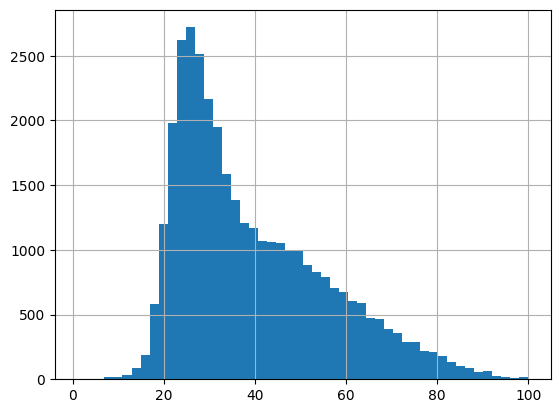

In [3]:
cropped_images['label'].hist(bins=50)

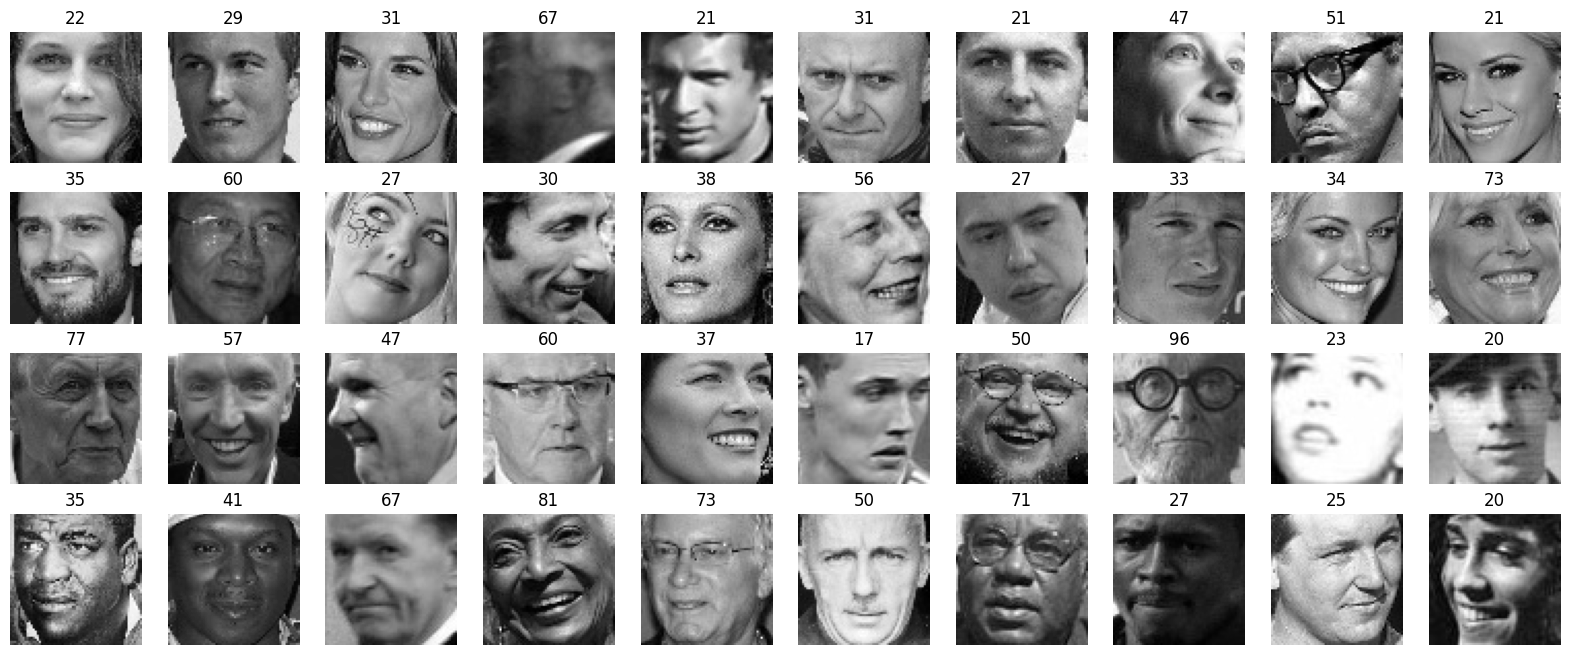

In [4]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

In [6]:
cropped_images.head()

,file_path,label
0,final_folder\10049200_1891-09-16_1958.jpg,67
1,final_folder\10110600_1985-09-17_2012.jpg,27
2,final_folder\1013900_1917-10-15_1960.jpg,43
3,final_folder\10166400_1960-03-12_2008.jpg,48
4,final_folder\10292500_1984-03-26_2009.jpg,25


In [7]:
cropped_images.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35070 entries, 0 to 35069
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  35070 non-null  object
 1   label      35070 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 822.0+ KB


In [3]:
cropped_images['label'] = cropped_images['label'].astype(np.int32)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cropped_images, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [14]:
TARGET_SIZE = (64, 64)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
color_mode='grayscale',
target_size=TARGET_SIZE,class_mode="raw")

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
color_mode='grayscale',
target_size=TARGET_SIZE,class_mode="raw")

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="file_path",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
color_mode='grayscale',
target_size=TARGET_SIZE, class_mode="raw")

Found 19640 validated image filenames.
Found 8416 validated image filenames.
Found 7014 validated image filenames.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [7]:
tf.random.set_seed(42)

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="age_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

In [54]:
inputs = keras.Input(shape=(64, 64, 1), name="img")
x = layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.MaxPooling2D((2, 2)) (x)
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = layers.MaxPooling2D((2, 2)) (x)
x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = layers.MaxPooling2D((2, 2)) (x)
x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = layers.Flatten() (x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs, outputs, name="age-pred")


model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['mae'])


In [55]:
model.summary()

Model: "age-pred"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 12, 12, 128)       738

In [56]:
history = model.fit(
                    train_generator, 
                    validation_data=valid_generator, 
                    epochs=50, 
                    callbacks=callbacks
                    )

Epoch 1/50
614/614 [==============================] - 11s 17ms/step - loss: 328.2282 - mae: 14.2529 - val_loss: 261.4780 - val_mae: 12.9249
Epoch 2/50
614/614 [==============================] - 10s 17ms/step - loss: 281.2948 - mae: 13.2915 - val_loss: 218.1004 - val_mae: 11.8478
Epoch 3/50
614/614 [==============================] - 10s 17ms/step - loss: 234.2534 - mae: 11.9855 - val_loss: 219.2013 - val_mae: 11.0507
Epoch 4/50
614/614 [==============================] - 10s 16ms/step - loss: 209.2940 - mae: 11.2287 - val_loss: 197.3456 - val_mae: 10.4666
Epoch 5/50
614/614 [==============================] - 10s 16ms/step - loss: 192.7039 - mae: 10.7179 - val_loss: 195.9785 - val_mae: 10.2972
Epoch 6/50
614/614 [==============================] - 10s 17ms/step - loss: 177.6252 - mae: 10.2018 - val_loss: 169.5959 - val_mae: 9.6152
Epoch 7/50
614/614 [==============================] - 10s 16ms/step - loss: 163.8963 - mae: 9.7665 - val_loss: 164.2400 - val_mae: 9.9602
Epoch 8/50
614/614 [===

<Axes: >

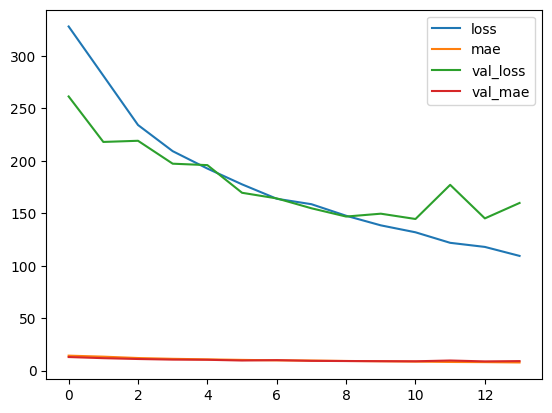

In [57]:
# Визуализация
pd.DataFrame(history.history).plot()

Посмотрим на метрику mae

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [59]:
predictions = model.predict(test_generator)

220/220 [==============================] - 3s 11ms/step


In [ ]:
test_generator.labels

array([38, 23, 22, ..., 42, 92, 26])

In [61]:
predictions

array([[40.13951 ],
       [24.969856],
       [48.62214 ],
       ...,
       [31.32358 ],
       [42.244022],
       [19.861275]], dtype=float32)

In [62]:
mae1 = mean_absolute_error(predictions, test_generator.labels)
mae1

16.615366801938205

Удалим модель и очистим память

In [25]:
del model

In [24]:
import tensorflow as tf
from numba import cuda

# Освобождение памяти на GPU
tf.keras.backend.clear_session()
cuda.select_device(0)
cuda.close()

Попробуем использовать готовую модель EfficientNetB4

In [8]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras import layers

Изменим размер изображений на 224х224 и сделаем цветным

In [9]:
TARGET_SIZE = (224, 224)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb',
target_size=TARGET_SIZE,class_mode="raw")

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb',
target_size=TARGET_SIZE,class_mode="raw")

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="file_path",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb',
target_size=TARGET_SIZE, class_mode="raw")

Found 19640 validated image filenames.
Found 8416 validated image filenames.
Found 7014 validated image filenames.


In [10]:
# Загрузка предобученной модели EfficientNetB4 без последнего слоя
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Размораживаем 2 верхних свертки
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Добавляем свой слой для регрессии
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = Dense(1, activation='linear')(x) 

# Создаем финальную модель
model = Model(inputs=base_model.input, outputs=output)

# Компиляция модели
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="EfficientNetB4_age_model.h5",
        save_weights_only=True,
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [13]:
history = model.fit(
                    train_generator, 
                    validation_data=valid_generator, 
                    epochs=50, 
                    callbacks=callbacks
                    )

Epoch 1/50
614/614 [==============================] - 173s 262ms/step - loss: 330.5077 - mae: 14.4758 - val_loss: 283.4136 - val_mae: 13.1513
Epoch 2/50
614/614 [==============================] - 156s 255ms/step - loss: 302.4244 - mae: 13.9996 - val_loss: 270.9307 - val_mae: 13.5737
Epoch 3/50
614/614 [==============================] - 155s 253ms/step - loss: 299.9970 - mae: 14.0109 - val_loss: 273.6017 - val_mae: 13.3045
Epoch 4/50
614/614 [==============================] - 157s 256ms/step - loss: 299.9495 - mae: 13.9417 - val_loss: 273.2757 - val_mae: 13.8487
Epoch 5/50
614/614 [==============================] - 158s 258ms/step - loss: 297.3797 - mae: 13.9118 - val_loss: 319.7793 - val_mae: 13.2118


<Axes: >

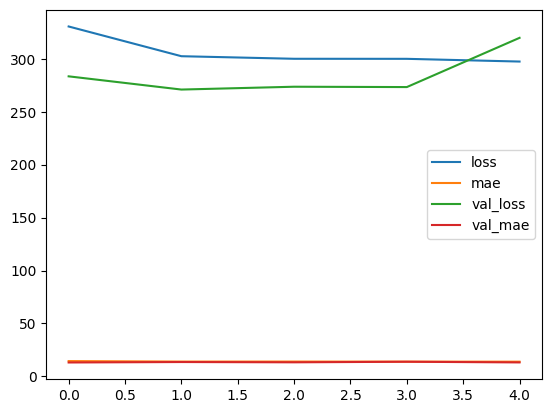

In [14]:
# Визуализация
pd.DataFrame(history.history).plot()

In [15]:
predictions = model.predict(test_generator)

220/220 [==============================] - 40s 171ms/step


In [22]:
test_generator.labels[:20]

array([38, 23, 22, 52, 16, 33, 42, 26, 24, 56, 26, 65, 43, 61, 29, 36, 27,
       31, 29, 21])

In [21]:
predictions[:20]

array([[41.0305  ],
       [39.18657 ],
       [39.293217],
       [41.31962 ],
       [38.73608 ],
       [38.583927],
       [39.48386 ],
       [38.22966 ],
       [40.99834 ],
       [39.497017],
       [40.336945],
       [40.028282],
       [38.667225],
       [39.623817],
       [39.157913],
       [39.9619  ],
       [39.498165],
       [39.486782],
       [38.635315],
       [39.078033]], dtype=float32)

In [20]:
mae1 = mean_absolute_error(predictions, test_generator.labels)
mae1

14.084948578076652

## Вывод

Модель которую определил я сам сработала лучше чем дообученная модель EfficientNetB4.
Несмотря на метрику mae, т.к. видно что EfficientNetB4 просто начала давать среднее значение.

